# CS 109A/AC 209A/STAT 121A Data Science: Lab 8
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize and Guatamala from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.

Each of the following files contain a small sample of locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise.

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.


### Step 1: Load the data and explore

Let's load the four datasets and visualize the data. That is, let's plot the data points by longitude and latitude. Let's also color code the points: green if the location is vegetation and white otherwise.

In [3]:
#Load the data from satellite image #1 
sat_img_1 = pd.read_csv('datasets/dataset_1.txt', delimiter=',', header=None)
#Check out the data - sanity check
sat_img_1.head()

,0,1,2
0,0.566809,0.788130,1
1,0.400046,0.620933,1
2,0.458702,0.536935,1
3,0.474504,0.638224,1
4,0.558707,0.715527,1


In [4]:
#The data looks ok, so let's load the rest of the images
sat_img_2 = pd.read_csv('datasets/dataset_2.txt', delimiter=',', header=None)
sat_img_3 = pd.read_csv('datasets/dataset_3.txt', delimiter=',', header=None)
sat_img_4 = pd.read_csv('datasets/dataset_4.txt', delimiter=',', header=None)

#Make a list of the four dataframes so we can iterate through them later
sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]

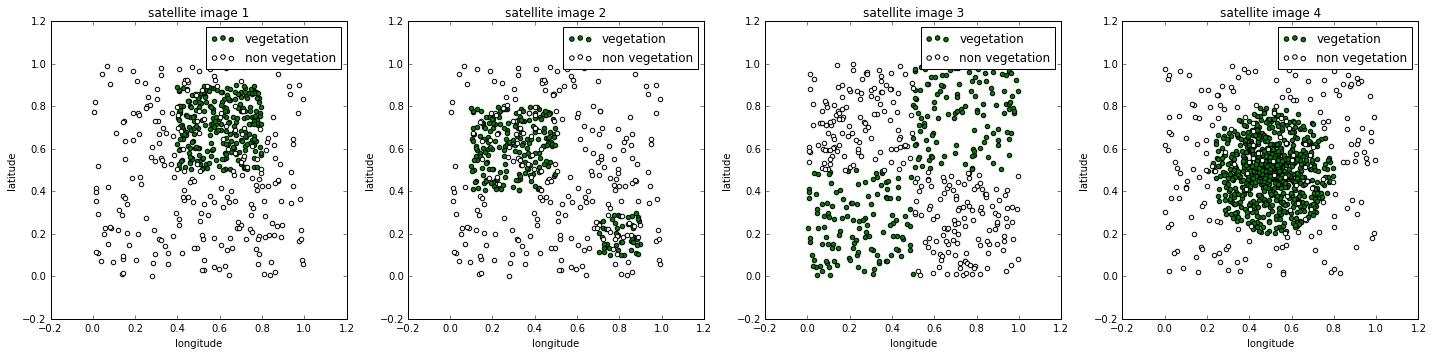

In [5]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]
    
    #Plot vegetation locations as green dots
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
    #Plot non-vegetation locations as white dots
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation')
    
    #Label everything
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    
plt.tight_layout()
plt.show() 

For each image, based on the sample of we want to train a classifier that will classify a location as vegetation or non-vegetation.

Since the vegetation seem to be clustered in isolated regions in each image. Classifying locations with vegetation involves learning a boundary around each region. We then classify the points inside this region as vegetation and points outside as non-vegetation.

Formally speaking, the vegetation regions in an image can be identified by treating the latitude and longitude values as predictors and the vegetation information as a binary response, and fitting a classification model. The decision boundaries of these classifiers then allow us to identify the vegetation regions.

### Step 2: Classify locations with vegetation

How can we use the models we have studied so far to identify the boundaries of the vegetation regions? 

Let's consider:

    1. linear or polynomial logistic regression
    2. linear or quadratic discriminant analysis
    3. decision trees

Looking at the data, can you intuitively tell which model will perform best on which data set? 

What do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case?

We've built you a helper function to visualize the decision boundaries of logistic regression models, LDA and QDA models. Use it to first assess the performance of logistic regression (linear and polynomial) and L/QDA models.

(***Experimentation Suggested***)

In [6]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

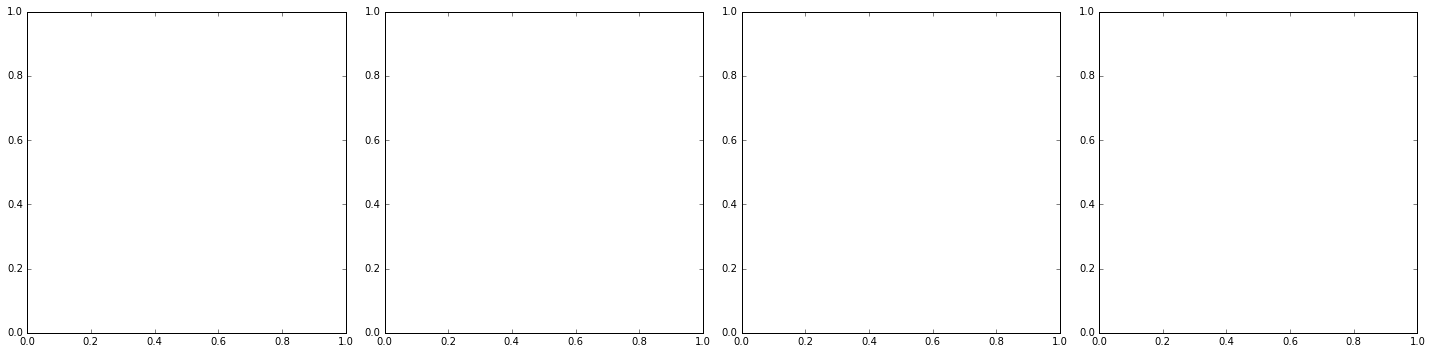

In [7]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Create a logistic regression model with linear boundary


#Iterate through the four images/dataframes

    #Get the long/lat coords
    
    #Get the class labels
        
    
    #Fit our logistic regression model
    
    
    #Plot the data along with the decision boundary learned by our model
    

plt.tight_layout()
plt.show()

From your experimentation above, can you conclude which model will perform best on which data set? Why (as in, what specific characteristics of each model makes it well or ill suited for each dataset)?

For fitting decision trees, we've built you a couple of helper functions to visualize the decision bounaries of a decision tree model on the data set. 

In [83]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [84]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

Try fitting decision trees of various depths to each of the datasets. Which depth is best for which dataset? Why and is the result of using `sklearn`'s decision tree model what you expect?

(***Experimentation Suggested***)

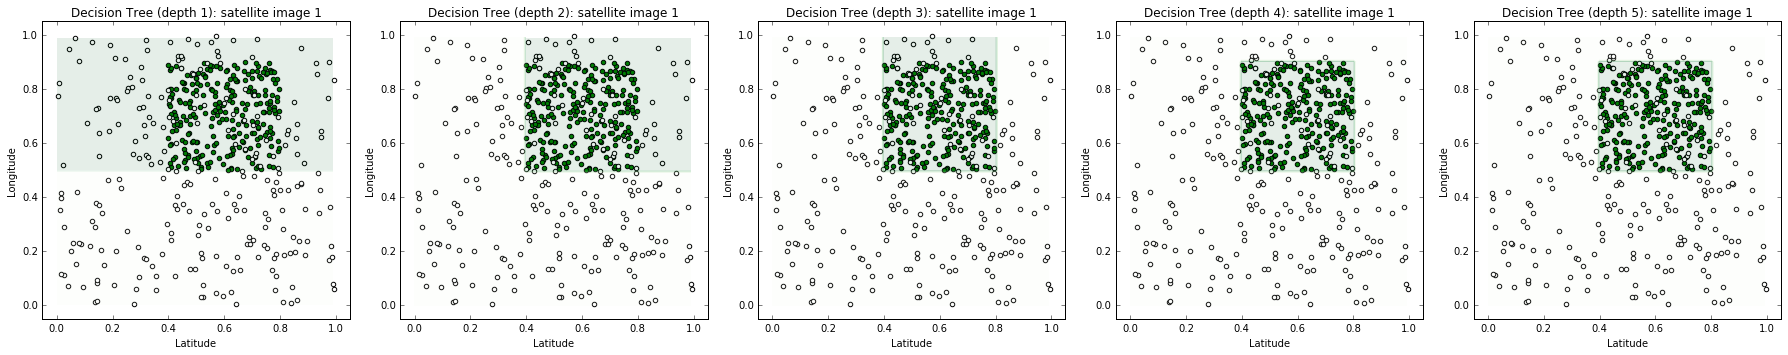

In [101]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[0].values[:, :-1]
#Get the class labels
y = sat_images[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 1'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

### Step 3: Evaluate our modeling choices

Recall that when creating our decision tree, we can decide on a split according classification error, Gini coefficient, and Entropy criteria. Which criterion is better, i.e. yield a better model? Or perhaps all three criteria will always produce the same splits?

Let's explore these three criteria using a simple example.

Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. $((11,37), (40,12))$  
2. $((25,48), (26,1))$

We've built three helper functions to compute the accuracy, Gini coefficient and the cross-entropy for a binary split. Use them to evaluate the above two splits.

(***Experimentation Suggested***)

In [8]:
# Calculate classification accuracy for a binary split
def err(x1, x2):
    return min((x1,x2))

# Calculate Gini coefficient for a binary split
def Gini(x1, x2):
    return x1*(1-x1) + x2*(1-x2)

# Calculate Cross-entropy for a binary split
def entropy(x1, x2):
    return -x1*log(x1) - x2*log(x2)

What is the default criterion `sklearn` uses in its decision tree classifier model? Will changing this criterion make any difference in terms of the preformance of our classifier on the satellite images?